Import Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer

import plotly.io as pio
pio.renderers
pio.renderers.default = "browser"

import Preprocess as pp
import Viz as viz

np.set_printoptions(precision = 3)

Set defaults

In [2]:
RANDOM_STATE = 42

df, column_trans, idx = pp.preprocessData()

log scaled ['total_sale_price', 'assessed_building_value', 'heated_area', 'unemploy_rate', 'pop_growth_rate', 'covid_cases', 'lumber_price', 'metals_price', 'supply', 'assessed_value_per_heated_area']
std scales ['story_height', 'mort_rate', 'build_price', 'int_rate', 'demand', 'year', 'crime']


In [3]:
column_trans

ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                 ['physical_zip_code', 'physical_city']),
                                ('log_scaled',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_sale_price', 'assessed_building_value',
                                  'heated_area', 'unemploy_rate',
                                  'pop_growth_r...vid_cases',
                                  'lumber_price', 'metals_price', 'supply',
                                  'assessed_value_per_heated_area']),
                                ('mm_scaled', MinMaxScaler(),
                                 ['bath_fixtures', 'bath']),
                                ('std_scale', StandardScaler(),
                                 ['story_height', 'mort_rate', 'build_price',
                                  'int_rate', 'demand', 'year', 'crime']),
                                ('passthru', 'passthrough',
                                 ['electric', 'gas', 'water', 'sewer', 'all',
                                  'is_covid', 'covid_year_timeline'])])

In [4]:
idx

{'onehot': slice(0, 43, None),
 'log_scaled': slice(43, 53, None),
 'mm_scaled': slice(53, 55, None),
 'std_scale': slice(55, 62, None),
 'passthru': slice(62, 69, None),
 'remainder': slice(0, 0, None)}

In [5]:
#samples for running Silhouette Score to shortern processing time
sample_full = pd.DataFrame(df).sample(frac=0.2, replace=False, random_state=RANDOM_STATE).reset_index().drop(columns=['index'])


K-Means Clustering

Elbow Method

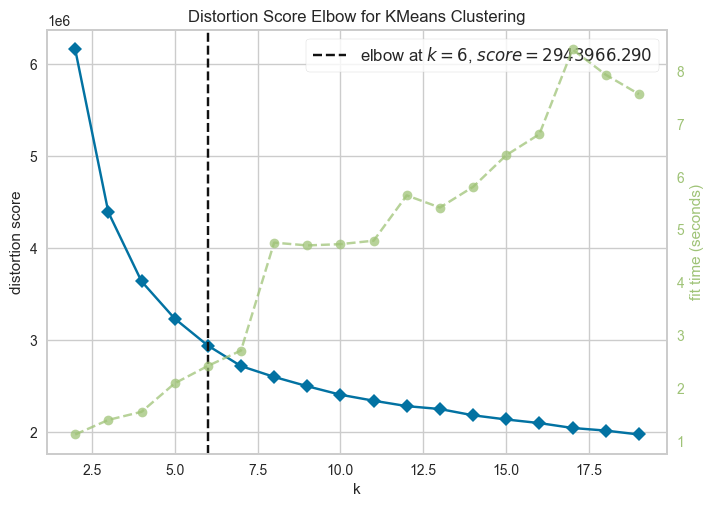

In [6]:
# initiate kmeans instance
kmeans = KMeans(init='k-means++', random_state=RANDOM_STATE)

# show results for full dataset
elb_visualizer = KElbowVisualizer(kmeans, k=(2,20)).fit(df).show()  

Silhouette Score

For n_clusters = 4 The average silhouette_score is : 0.3125531861532554
For n_clusters = 5 The average silhouette_score is : 0.29221487475866903
For n_clusters = 6 The average silhouette_score is : 0.25343957901703645
For n_clusters = 7 The average silhouette_score is : 0.25551898475639895


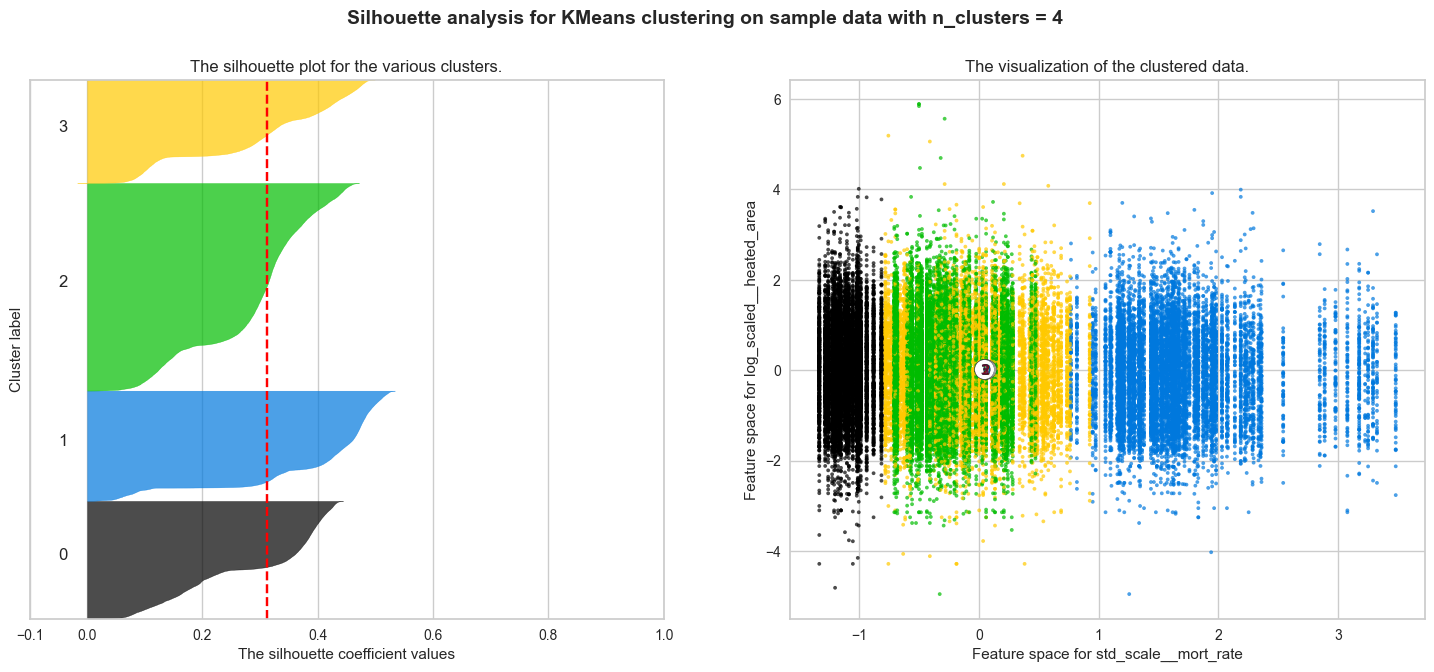

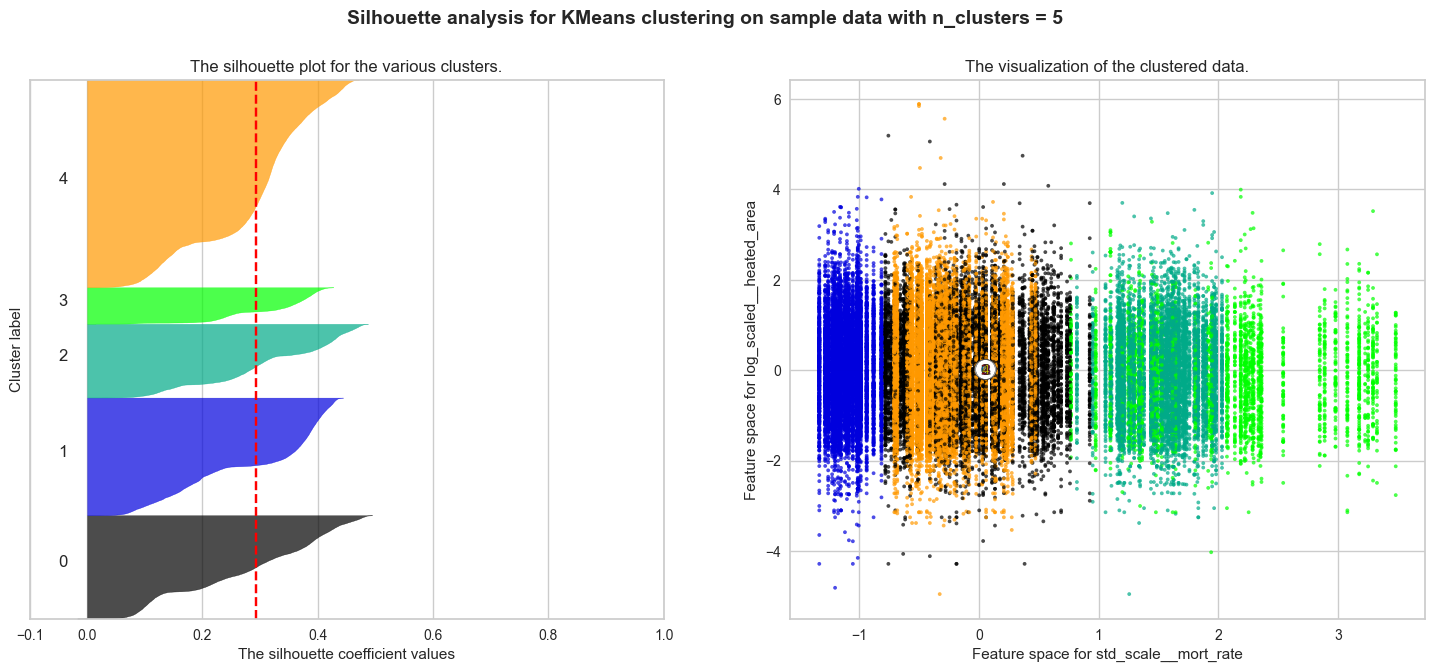

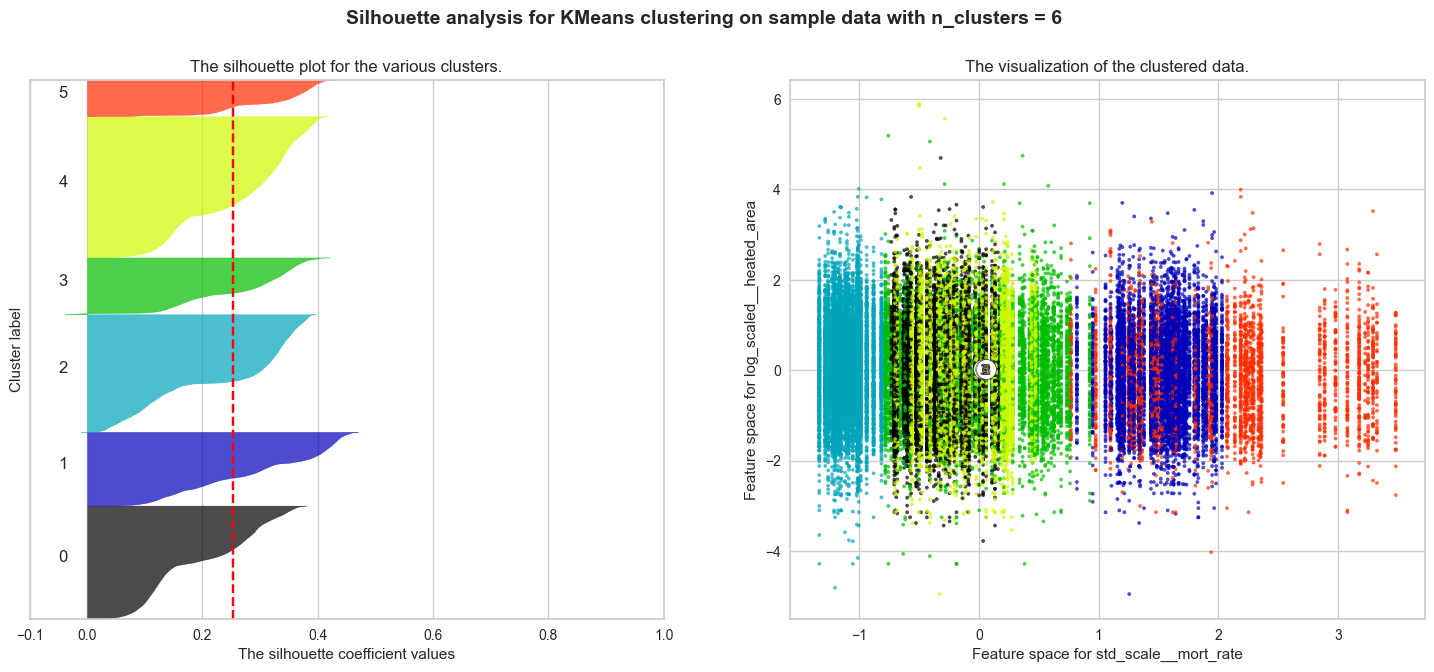

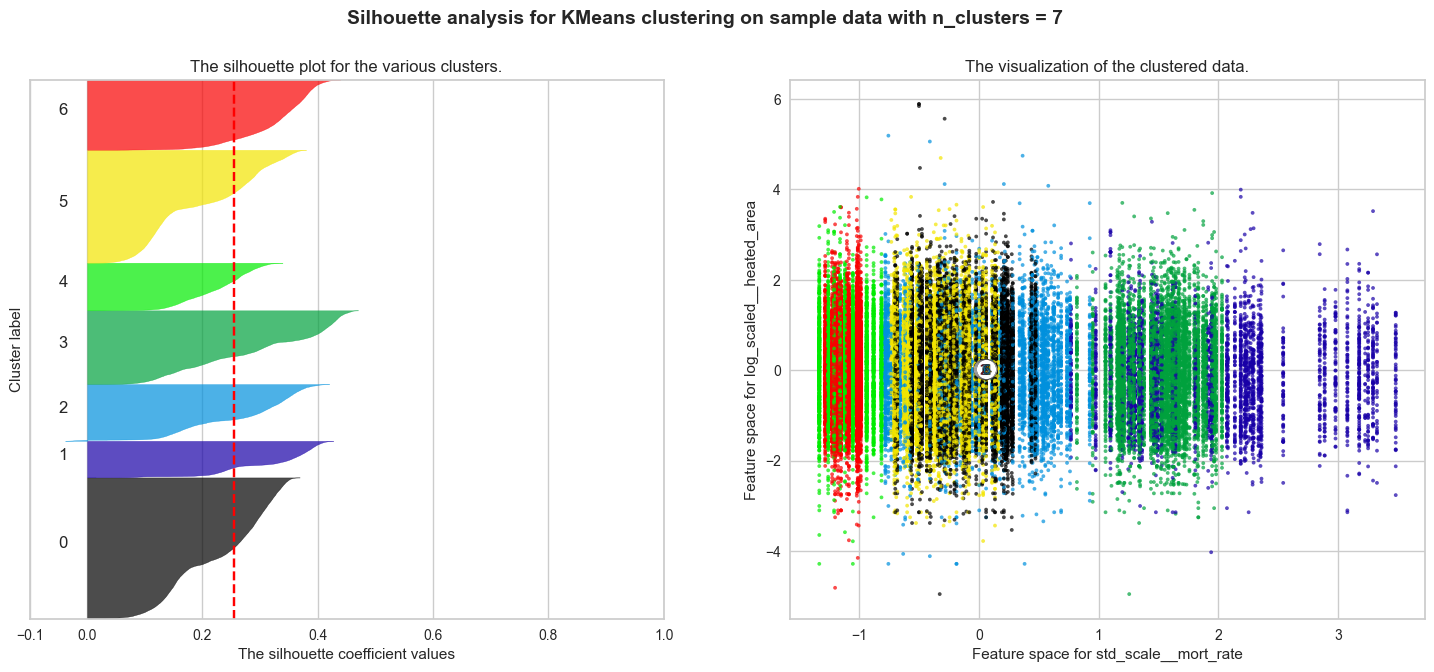

In [9]:
range_n_clusters = [4, 5, 6, 7]
ax = 'std_scale__mort_rate'
ay = 'log_scaled__heated_area'

viz.draw_silhouette(X=sample_full, k=range_n_clusters, ax=ax, ay=ay, random_state=RANDOM_STATE)

Overlaying Clusters on Scaled Data

In [1]:
selected_k=4

viz.draw_cluster_scatter(X=sample_full, k=selected_k, random_state=RANDOM_STATE)



NameError: name 'viz' is not defined